In [1]:
#@title Load Python libraries

! pip install pandas fiona shapely pyproj rtree
! pip install alpha_vantage -q
! pip install regions
! pip install geopandas

# pip install numpy
import numpy as np


# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import regions

import pandas as pd
import seaborn as sns
import datetime

#pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.animation as animation

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries 

from geopandas.tools import sjoin

print("All libraries loaded")

     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 6.3 MB 12.0 MB/s 
     |████████████████████████████████| 994 kB 46.1 MB/s 
     |████████████████████████████████| 1.3 MB 9.3 MB/s 
     |████████████████████████████████| 294 kB 60.5 MB/s 
     |████████████████████████████████| 142 kB 75.9 MB/s 
     |████████████████████████████████| 744 kB 7.5 MB/s 
     |████████████████████████████████| 994 kB 7.3 MB/s 
All libraries loaded


In [2]:
config = {
    #"alpha_vantage": {
    #    "key": "YOUR_API_KEY", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
     #   "symbol": "IBM",
     #   "outputsize": "full",
     #   "key_adjusted_close": "5. adjusted close",
    #},
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [3]:
# select the "Swarms.csv" from your local project drive
from google.colab import files
uploaded = files.upload()

# see the head of the dataframe
import io
import pandas as pd

df_swarms = pd.read_csv(io.BytesIO(uploaded['Swarms.csv']))

Saving Swarms.csv to Swarms.csv


In [5]:
df_swarms.head()

,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,SHPMATINS4,SHPMATINS5,SHPMATINS6,SHPMATFLED,...,GADMATIMMA,GADMATMATG,GADMATMAT,GADMATCOP,GADMATLAY,GADMATUNK,GADCOLYL,GADCOLRD,GADMINASKM,GADMAXASKM,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT
0,-15.131944,17.870278,1,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211460,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm
1,-15.400278,18.030833,2,1985/11/26 00:00:00+00,12:00,1985/11/26 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211461,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm
2,-14.668889,17.988889,3,1985/11/27 00:00:00+00,12:00,1985/11/27 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211462,RAMSES38_NRI85-01.XL,(**RefFalse----116-0,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1985/11/27 00:00:00+00,1985/11/27 00:00:00+00,2,3,Unknown,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm
3,-14.633333,17.835833,4,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211463,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm
4,-13.353889,18.026389,5,1985/10/15 00:00:00+00,12:00,1985/10/15 00:00:00+00,12:00,Yes,,,0.0,Exact,MR,211937,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm


In [4]:
#df_swarms.describe()
coords_df = df_swarms.loc[:, ['X', 'Y']]
coords_df.describe()

,X,Y
count,37541.000000,37541.000000
mean,22.547103,18.328307
std,28.532293,10.570836
min,-25.160000,-4.254444
25%,-7.150000,10.004444
50%,35.686667,17.969722
75%,41.026944,27.950000
max,83.281389,41.766667


In [5]:
# Mark the duplicate and unique locations with 0.0001 precision in Swarms dataframe
coords_df['Status'] = 'Unique'
coords_df.loc[coords_df[coords_df.loc[:, ['X', 'Y']].round(4).duplicated(keep=False)].index, 'Status'] = 'Possible duplicate'
coords_df.tail()

# Show the number of duplicate observations in "Swarms.csv" 
print("Number of possible duplicate: ",len(coords_df[coords_df['Status'] == "Possible duplicate"]))

# Show the number of unique observations in "Swarms.csv" 
print("Unique point: ",len(coords_df[coords_df['Status'] == "Unique"]))

Number of possible duplicate:  11222
Unique point:  26319


In [6]:
# find the observations in dataframe that are "Unique" + "Present" + "Reliable"
df_swarms['Status'] = 'Unique'
df_swarms.loc[df_swarms[df_swarms.loc[:, ['X', 'Y']].round(4).duplicated(keep=False)].index, 'Status'] = 'Possible duplicate'

pruned_df = df_swarms.loc[(df_swarms['Status']=="Unique") & df_swarms['REPRELIAB'] == 1]

In [7]:
pruned_df.head()

,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,SHPMATINS4,SHPMATINS5,SHPMATINS6,SHPMATFLED,...,GADMATMATG,GADMATMAT,GADMATCOP,GADMATLAY,GADMATUNK,GADCOLYL,GADCOLRD,GADMINASKM,GADMAXASKM,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,Status
0,-15.131944,17.870278,1,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211460,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique
1,-15.400278,18.030833,2,1985/11/26 00:00:00+00,12:00,1985/11/26 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211461,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique
2,-14.668889,17.988889,3,1985/11/27 00:00:00+00,12:00,1985/11/27 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211462,RAMSES38_NRI85-01.XL,(**RefFalse----116-0,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1985/11/27 00:00:00+00,1985/11/27 00:00:00+00,2,3,Unknown,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique
3,-14.633333,17.835833,4,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211463,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique
4,-13.353889,18.026389,5,1985/10/15 00:00:00+00,12:00,1985/10/15 00:00:00+00,12:00,Yes,,,0.0,Exact,MR,211937,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique


In [8]:
import geopandas as gpd
# import rtree
# import pygeos

In [9]:
gdf = gpd.GeoDataFrame(
    pruned_df, geometry=gpd.points_from_xy(pruned_df.X, pruned_df.Y))

gdf.set_crs(epsg=4326, inplace=True)

,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,SHPMATINS4,SHPMATINS5,SHPMATINS6,SHPMATFLED,...,GADMATMAT,GADMATCOP,GADMATLAY,GADMATUNK,GADCOLYL,GADCOLRD,GADMINASKM,GADMAXASKM,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,Status,geometry
0,-15.131944,17.870278,1,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211460,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-15.13194 17.87028)
1,-15.400278,18.030833,2,1985/11/26 00:00:00+00,12:00,1985/11/26 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211461,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-15.40028 18.03083)
2,-14.668889,17.988889,3,1985/11/27 00:00:00+00,12:00,1985/11/27 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211462,RAMSES38_NRI85-01.XL,(**RefFalse----116-0,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1985/11/27 00:00:00+00,1985/11/27 00:00:00+00,2,3,Unknown,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-14.66889 17.98889)
3,-14.633333,17.835833,4,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211463,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-14.63333 17.83583)
4,-13.353889,18.026389,5,1985/10/15 00:00:00+00,12:00,1985/10/15 00:00:00+00,12:00,Yes,,,0.0,Exact,MR,211937,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-13.35389 18.02639)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37535,39.962778,10.735000,60991,2021/07/02 21:59:59+00,05:09,2021/07/02 21:59:59+00,05:09,No,Early,Am Oromo Dharawa Din,1000.0,Exact,ET,799079,RAMSES38_ETH21-52.XL,(eL3). Flying time:,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.1,0.1,1,0,0,0,0,0,0,0,0,1,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (39.96278 10.73500)
37536,39.038611,12.263889,60992,2021/07/01 21:59:59+00,00:00,2021/07/01 21:59:59+00,00:00,No,Early,Waghimera /Gazgibla/,500.0,Exact,ET,799092,RAMSES38_ETH21-52.XL,Appversion624OSversi,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (39.03861 12.26389)
37538,44.330556,10.107500,60994,2021/07/30 21:59:59+00,09:47,2021/07/30 21:59:59+00,09:47,No,Late,North of Boocley,100.0,Exact,SO,805053,RAMSES38_SOM21-128.X,(eL3),1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1

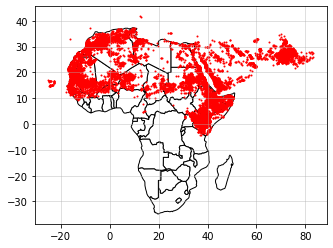

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to Africa.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red', markersize=1)
ax.grid(b=True, alpha=0.5)
plt.show()

In [11]:
point = gdf.geometry
point

0        POINT (-15.13194 17.87028)
1        POINT (-15.40028 18.03083)
2        POINT (-14.66889 17.98889)
3        POINT (-14.63333 17.83583)
4        POINT (-13.35389 18.02639)
                    ...            
37535     POINT (39.96278 10.73500)
37536     POINT (39.03861 12.26389)
37538     POINT (44.33056 10.10750)
37539     POINT (45.31361 13.63778)
37540     POINT (42.64778 11.21528)
Name: geometry, Length: 26091, dtype: geometry

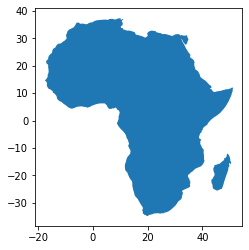

In [12]:
ax = world[world.continent == 'Africa'].dissolve().plot()

In [13]:
africa = world[world.continent == 'Africa'].dissolve().geometry

gdf.within(africa).describe()

/usr/local/lib/python3.7/dist-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


count     26091
unique        2
top       False
freq      26090
dtype: object

In [24]:
africa_df = world[world.continent == 'Africa'].dissolve()
africa_df = africa_df.drop(['pop_est','iso_a3','name','gdp_md_est'],axis=1)
africa_df

,geometry,continent,name
0,"MULTIPOLYGON (((32.83012 -26.74219, 32.58026 -...",Africa,Tanzania


In [15]:
#gdf[gdf.within(africa)]

join_df = sjoin(gdf, africa_df, how="left")
len(join_df)

26091

In [ ]:
join_df

In [32]:
join_df_ind = sjoin(gdf, world[world.continent == 'Africa'], how="left")

recorded_country = join_df_ind.name.unique()

In [16]:
#join_df.continent.describe()

count      20462
unique         1
top       Africa
freq       20462
Name: continent, dtype: object

In [17]:
clean_df = join_df.dropna(axis=0, how='any')
len(clean_df)

15973

In [18]:
clean_df.head()

,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,SHPMATINS4,SHPMATINS5,SHPMATINS6,SHPMATFLED,...,GADMATLAY,GADMATUNK,GADCOLYL,GADCOLRD,GADMINASKM,GADMAXASKM,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,Status,geometry,index_right,continent
0,-15.131944,17.870278,1,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211460,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-15.13194 17.87028),0.0,Africa
1,-15.400278,18.030833,2,1985/11/26 00:00:00+00,12:00,1985/11/26 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211461,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-15.40028 18.03083),0.0,Africa
2,-14.668889,17.988889,3,1985/11/27 00:00:00+00,12:00,1985/11/27 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211462,RAMSES38_NRI85-01.XL,(**RefFalse----116-0,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1985/11/27 00:00:00+00,1985/11/27 00:00:00+00,2,3,Unknown,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-14.66889 17.98889),0.0,Africa
3,-14.633333,17.835833,4,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211463,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-14.63333 17.83583),0.0,Africa
4,-13.353889,18.026389,5,1985/10/15 00:00:00+00,12:00,1985/10/15 00:00:00+00,12:00,Yes,,,0.0,Exact,MR,211937,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-13.35389 18.02639),0.0,Africa


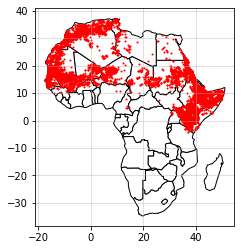

In [19]:
# We restrict to Africa.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
clean_df.plot(ax=ax, color='red', markersize=1)

ax.grid(b=True, alpha=0.5)
plt.show()

In [22]:
# from google.colab import files
# uploaded_ecology = files.upload()

# # see the head of the dataframe
# import io
# import pandas as pd

# df_ecology = pd.read_csv(io.BytesIO(uploaded_ecology['Ecology.csv']))

In [23]:
# clean_df['round_X'] = round(clean_df['X'],3)
# clean_df['round_Y'] = round(clean_df['Y'],3)

# df_ecology['round_X'] = round(df_ecology['X'],3)
# df_ecology['round_Y'] = round(df_ecology['Y'],3)
# df_ecology = df_ecology.drop(['X','Y'],axis=1)

In [25]:
# eco_join = sjoin(clean_df, df_ecology, how="left")

In [21]:
#recorded_country = list(set(clean_df['COUNTRYID']))

In [33]:
# from google.colab import files
# uploaded_country = files.upload()

# # see the head of the dataframe
# import io
# import pandas as pd

# df_country_origin = pd.read_csv(io.BytesIO(uploaded_country['countries_code.csv']))

# df_country = df_country_origin

In [90]:
# df_country['Alpha-2 code'] = df_country['Alpha-2 code'].str.replace('"', "")
# df_country['Alpha-2 code'] = df_country['Alpha-2 code'].str.replace(" ", "")

# df_country['Alpha-3 code'] = df_country['Alpha-3 code'].str.replace('"', "")
# df_country['Alpha-3 code'] = df_country['Alpha-3 code'].str.replace(" ", "")

In [37]:
# country_subset = df_country[df_country['Alpha-2 code'].isin(recorded_country)]
# country_subset

In [89]:
# df_country = df_country[df_country['Alpha-2 code'].isin(recorded_country)]
# df_country['iso_a3'] = df_country['Alpha-3 code']

In [46]:
subset_gdf = world.name.isin(recorded_country)

country_gdf = world[subset_gdf]

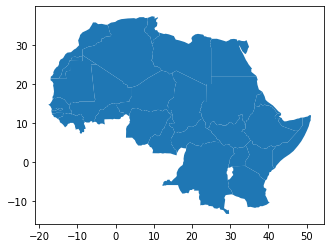

In [47]:
#country_gdf = world.merge(df_country, on='iso_a3')
country_gdf.plot()

In [48]:
clean_df = clean_df.to_crs("EPSG:32634")
world = world.to_crs("EPSG:32634")

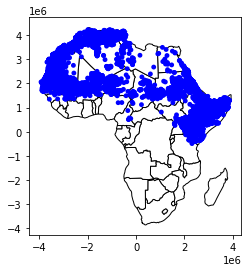

In [49]:
buffer = clean_df.geometry.buffer(100*1000)

# We restrict to Africa.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
buffer.plot(ax=ax, color='blue')

plt.show()

In [50]:
clean_df.head()

,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,SHPMATINS4,SHPMATINS5,SHPMATINS6,SHPMATFLED,...,GADMATLAY,GADMATUNK,GADCOLYL,GADCOLRD,GADMINASKM,GADMAXASKM,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,Status,geometry,index_right,continent
0,-15.131944,17.870278,1,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211460,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-3548696.725 2409863.041),0.0,Africa
1,-15.400278,18.030833,2,1985/11/26 00:00:00+00,12:00,1985/11/26 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211461,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-3577503.964 2438457.581),0.0,Africa
2,-14.668889,17.988889,3,1985/11/27 00:00:00+00,12:00,1985/11/27 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211462,RAMSES38_NRI85-01.XL,(**RefFalse----116-0,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1985/11/27 00:00:00+00,1985/11/27 00:00:00+00,2,3,Unknown,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-3487503.425 2412410.712),0.0,Africa
3,-14.633333,17.835833,4,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211463,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-3487479.893 2391538.291),0.0,Africa
4,-13.353889,18.026389,5,1985/10/15 00:00:00+00,12:00,1985/10/15 00:00:00+00,12:00,Yes,,,0.0,Exact,MR,211937,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-3323929.066 2381963.899),0.0,Africa


In [51]:
training_df = clean_df.loc[(clean_df['FINISHDATE'] >= "1985/01/01 00:00:00+00") & (clean_df['FINISHDATE'] <= "2015/12/31 00:00:00+00") ]

month_col_vals = pd.DatetimeIndex(training_df.loc[:,'FINISHDATE']).month

training_df.insert(2, "Month", month_col_vals, True)

year_col_vals = pd.DatetimeIndex(training_df.loc[:,'FINISHDATE']).year

training_df.insert(2, "Year", year_col_vals, True)

training_df.head()

,X,Y,Year,Month,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,SHPMATINS4,SHPMATINS5,...,GADMATLAY,GADMATUNK,GADCOLYL,GADCOLRD,GADMINASKM,GADMAXASKM,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,Status,geometry,index_right,continent
0,-15.131944,17.870278,1985,11,1,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211460,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-3548696.725 2409863.041),0.0,Africa
1,-15.400278,18.030833,1985,11,2,1985/11/26 00:00:00+00,12:00,1985/11/26 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211461,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-3577503.964 2438457.581),0.0,Africa
2,-14.668889,17.988889,1985,11,3,1985/11/27 00:00:00+00,12:00,1985/11/27 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211462,RAMSES38_NRI85-01.XL,(**RefFalse----116-0,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1985/11/27 00:00:00+00,1985/11/27 00:00:00+00,2,3,Unknown,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-3487503.425 2412410.712),0.0,Africa
3,-14.633333,17.835833,1985,11,4,1985/11/30 00:00:00+00,12:00,1985/11/30 00:00:00+00,12:00,No,Late,,0.0,Exact,MR,211463,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-3487479.893 2391538.291),0.0,Africa
4,-13.353889,18.026389,1985,10,5,1985/10/15 00:00:00+00,12:00,1985/10/15 00:00:00+00,12:00,Yes,,,0.0,Exact,MR,211937,RAMSES38_NRI85-01.XL,(**RefFalse----0-0-F,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,Unique,POINT (-3323929.066 2381963.899),0.0,Africa


In [72]:
len(training_df)

8257

In [80]:
present_df = training_df.where(training_df["LOCPRESENT"] == 1)#.where(training_df["BREEDING"] == 1)

In [81]:
present_df = present_df.dropna(how='all')

len(present_df)

8169

In [82]:
buffer = present_df.geometry.buffer(1000*1000)

buffer_training = gpd.GeoDataFrame(present_df, geometry = buffer)

In [83]:
buffer_training.geometry

0        POLYGON ((-2548696.725 2409863.041, -2553511.9...
1        POLYGON ((-2577503.964 2438457.581, -2582319.2...
2        POLYGON ((-2487503.425 2412410.712, -2492318.6...
3        POLYGON ((-2487479.893 2391538.291, -2492295.1...
4        POLYGON ((-2323929.066 2381963.899, -2328744.3...
                               ...                        
22247    POLYGON ((3359812.598 2058406.672, 3354997.325...
22248    POLYGON ((3358830.416 2071547.662, 3354015.142...
22251    POLYGON ((3304408.335 2106094.203, 3299593.062...
22253    POLYGON ((3303450.154 2105521.207, 3298634.880...
22254    POLYGON ((3357894.001 2066852.926, 3353078.727...
Name: geometry, Length: 8169, dtype: geometry

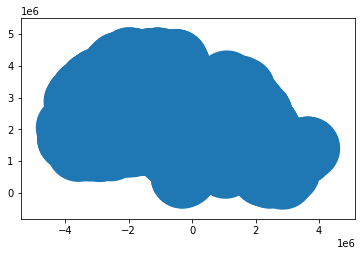

In [84]:
buffer_training.plot() # add jitter training presence points

In [85]:
#buffer_training.head()

In [86]:
buffer_training = buffer_training.to_crs("EPSG:4326")

outbreak_1985 = buffer_training[buffer_training['Year'] == 1985]

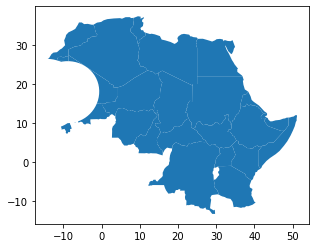

In [87]:
difference = gpd.overlay(country_gdf, outbreak_1985, how='difference')

difference.plot()

In [91]:
import shapely.geometry

def sample_point(geoseries, size, overestimate=2):
    polygon = geoseries.unary_union
    min_x, min_y, max_x, max_y = polygon.bounds
    ratio = polygon.area / polygon.envelope.area
    samples = np.random.uniform((min_x, min_y), (max_x, max_y), (int(size / ratio * overestimate), 2))
    multipoint = shapely.geometry.MultiPoint(samples)
    multipoint = multipoint.intersection(polygon)
    samples = np.array(multipoint)
    while samples.shape[0] < size:
        # emergency catch in case by bad luck we didn't get enough within the polygon
        samples = np.concatenate([samples, random_points_in_polygon(polygon, size, overestimate=overestimate)])
    return samples[np.random.choice(len(samples), size)]

In [92]:
absence_point = sample_point(difference, 1000)

In [93]:
absence_point[0]

array([31.80655766, 19.25658172])

In [ ]:
lon = []
lat = []

[(lon.append(i[0]),lat.append(i[1])) for i in absence_point]

In [95]:
absence_df = pd.DataFrame(
    {'X': lon, 'Y': lat}
)

gdf_absence = gpd.GeoDataFrame(
    absence_df, geometry=gpd.points_from_xy(absence_df.X, absence_df.Y))

gdf_absence = gdf_absence.set_crs("EPSG:4326")

In [96]:
world = world.to_crs("EPSG:4326")

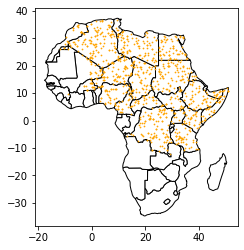

In [97]:
# We restrict to Africa.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf_absence.plot(ax=ax, color='orange', markersize=0.5)

plt.show()

In [98]:
gdf_absence['Year'] = 1985
gdf_absence.head()

,X,Y,geometry,Year
0,31.806558,19.256582,POINT (31.80656 19.25658),1985
1,31.510997,-6.971610,POINT (31.51100 -6.97161),1985
2,3.776219,19.604133,POINT (3.77622 19.60413),1985
3,46.760486,9.807432,POINT (46.76049 9.80743),1985
4,24.816406,-0.169188,POINT (24.81641 -0.16919),1985


In [99]:
def create_abs_point(buffer_training, size_per_month=100):
  buffer_training = buffer_training.to_crs("EPSG:4326")
  start_year = buffer_training['Year'].min()
  end_year = buffer_training['Year'].max()

  append_point = None
  append_allyr_point = None
  for year in np.arange(start_year,end_year + 1,1):
      for month in np.arange(1,13,1):
          outbreak = buffer_training[buffer_training['Year'] == year]
          difference = gpd.overlay(country_gdf, outbreak, how='difference')
          absence_point = sample_point(difference, size_per_month)

          lon = []
          lat = []
          [(lon.append(i[0]),lat.append(i[1])) for i in absence_point]

          absence_df = pd.DataFrame({'X': lon, 'Y': lat})

          gdf_absence = gpd.GeoDataFrame(
              absence_df, geometry=gpd.points_from_xy(absence_df.X, absence_df.Y))
          
          gdf_absence = gdf_absence.set_crs("EPSG:4326")

          gdf_absence['Year'] = year
          gdf_absence['Month'] = month

          if append_point is not None:
            append_point = append_point.append(gdf_absence)
          else:
            append_point = gdf_absence
  if append_allyr_point is not None:
      append_allyr_point = append_allyr_point.append(append_point)
  else:
      append_allyr_point = append_point

  return append_allyr_point


In [100]:
gen_abs_point = create_abs_point(buffer_training, size_per_month=100)
gen_abs_point

,X,Y,geometry,Year,Month
0,12.953325,8.830587,POINT (12.95333 8.83059),1985.0,1
1,44.172727,1.561905,POINT (44.17273 1.56190),1985.0,1
2,13.939077,14.999228,POINT (13.93908 14.99923),1985.0,1
3,34.682094,3.212091,POINT (34.68209 3.21209),1985.0,1
4,41.772839,1.033824,POINT (41.77284 1.03382),1985.0,1
...,...,...,...,...,...
95,-9.522212,27.919400,POINT (-9.52221 27.91940),2015.0,12
96,27.771672,-4.585728,POINT (27.77167 -4.58573),2015.0,12
97,-6.435243,34.383690,POINT (-6.43524 34.38369),2015.0,12
98,-5.088789,14.948077,POINT (-5.08879 14.94808),2015.0,12


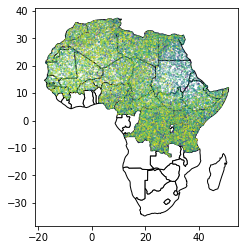

In [105]:
# We restrict to Africa.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gen_abs_point.plot(ax=ax, column='Year', markersize=0.05, alpha=0.8)

plt.show()

In [106]:
len(gen_abs_point)

37200

In [107]:
len(present_df)

8169

In [108]:
present_df.geometry

0        POINT (-3548696.725 2409863.041)
1        POINT (-3577503.964 2438457.581)
2        POINT (-3487503.425 2412410.712)
3        POINT (-3487479.893 2391538.291)
4        POINT (-3323929.066 2381963.899)
                       ...               
22247     POINT (2359812.598 2058406.672)
22248     POINT (2358830.416 2071547.662)
22251     POINT (2304408.335 2106094.203)
22253     POINT (2303450.154 2105521.207)
22254     POINT (2357894.001 2066852.926)
Name: geometry, Length: 8169, dtype: geometry

In [109]:
present_df = training_df.where(training_df["LOCPRESENT"] == 1)
present_in_m = present_df.to_crs("EPSG:32634")

In [110]:
present_in_m_shift = present_in_m
present_in_m_shift.geometry = present_in_m.translate(xoff=100,yoff=100)

present_in_m_shift2 = present_in_m
present_in_m_shift2.geometry = present_in_m.translate(xoff=200,yoff=-100)

present_in_m_shift3 = present_in_m
present_in_m_shift3.geometry = present_in_m.translate(xoff=-200,yoff=100)

In [111]:
present_in_m.geometry

0        POINT (-3548596.725 2409963.041)
1        POINT (-3577403.964 2438557.581)
2        POINT (-3487403.425 2412510.712)
3        POINT (-3487379.893 2391638.291)
4        POINT (-3323829.066 2382063.899)
                       ...               
22247     POINT (2359912.598 2058506.672)
22248     POINT (2358930.416 2071647.662)
22251     POINT (2304508.335 2106194.203)
22253     POINT (2303550.154 2105621.207)
22254     POINT (2357994.001 2066952.926)
Name: geometry, Length: 8257, dtype: geometry

In [112]:
present_in_m_shift.geometry

0        POINT (-3548596.725 2409963.041)
1        POINT (-3577403.964 2438557.581)
2        POINT (-3487403.425 2412510.712)
3        POINT (-3487379.893 2391638.291)
4        POINT (-3323829.066 2382063.899)
                       ...               
22247     POINT (2359912.598 2058506.672)
22248     POINT (2358930.416 2071647.662)
22251     POINT (2304508.335 2106194.203)
22253     POINT (2303550.154 2105621.207)
22254     POINT (2357994.001 2066952.926)
Name: geometry, Length: 8257, dtype: geometry

In [113]:
gen_presence_point = present_in_m.append(present_in_m_shift).append(present_in_m_shift2).append(present_in_m_shift3)

In [114]:
gen_presence_point = gen_presence_point.to_crs("EPSG:4326")

In [116]:
gen_presence_point = gen_presence_point.assign(PRESENCE=1)
gen_abs_point = gen_abs_point.assign(PRESENCE=0)

In [117]:
all_point = gen_abs_point.append(gen_presence_point)

In [118]:
all_training_point = all_point.where(all_point["Year"] < 2016)

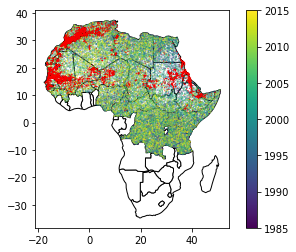

In [126]:
# We restrict to Africa.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
all_training_point.where(all_training_point.PRESENCE == 0).plot(ax=ax,column="Year", markersize=0.05, alpha=0.7, legend=True)
all_training_point.where(all_training_point.PRESENCE == 1).plot(ax=ax,color="red", markersize=0.008, alpha=0.5)

plt.show()

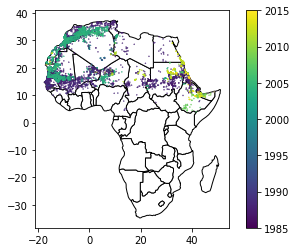

In [125]:
# We restrict to Africa.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
all_training_point.where(all_training_point.PRESENCE == 1).plot(ax=ax,column="Year", markersize=0.08, alpha=0.5, legend=True)
plt.show()

In [127]:
all_training_point.head()

,X,Y,geometry,Year,Month,PRESENCE,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,...,GADMATCOP,GADMATLAY,GADMATUNK,GADCOLYL,GADCOLRD,GADMINASKM,GADMAXASKM,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,Status,index_right,continent
0,12.953325,8.830587,POINT (12.95333 8.83059),1985.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44.172727,1.561905,POINT (44.17273 1.56190),1985.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13.939077,14.999228,POINT (13.93908 14.99923),1985.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34.682094,3.212091,POINT (34.68209 3.21209),1985.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41.772839,1.033824,POINT (41.77284 1.03382),1985.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
all_training_point.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [135]:
from google.colab import files
import pandas as pd

#all_training_point.to_file("locust_datapoint.shp")
#files.download('locust_datapoint.shp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [136]:
#files.download('locust_datapoint.shx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [138]:
#files.download('locust_datapoint.dbf'#)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#files.download('locust_datapoint.cpg')